In [1]:
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import time
# --- HÀM TẢI DỮ LIỆU TỪ BINANCE ---
def str_to_millis(date_str):
    dt = datetime.strptime(date_str, "%d/%m/%Y")
    return int(dt.timestamp() * 1000)

def fetch_binance_kline_df(symbol, interval, start_str, end_str):
    base_url = "https://api.binance.us/"
    api_url = "api/v3/klines"
    general_url = base_url + api_url

    start_time = str_to_millis(start_str)
    end_dt = datetime.strptime(end_str, "%d/%m/%Y").replace(hour=23, minute=59, second=59)
    end_time = int(end_dt.timestamp() * 1000)

    all_klines = []
    while start_time < end_time:
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000
        }
        response = requests.get(general_url, params=params)
        if response.status_code != 200:
            print("Error:", response.status_code, response.text)
            break

        data = response.json()
        if not data:
            break
        all_klines.extend(data)

        last_ts = data[-1][0]
        start_time = last_ts + 1
        time.sleep(0.2)

    df = pd.DataFrame(all_klines, columns=[
        "timestamp", "o", "h", "l", "c", "v",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
    ])
    df = df[["timestamp", "o", "c", "h", "l", "v"]]
    df.columns = ["timestamp", "o", "c", "h", "l", "v"]
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["o", "c", "h", "l", "v"]] = df[["o", "c", "h", "l", "v"]].astype(float)
    df["date"] = df["timestamp"].dt.date
    return df


In [ ]:
# --- NHẬP THỜI GIAN ---
symbol = "SOLUSDT"
interval = "30m"
start_date = "01/01/2025"
end_date = "30/06/2025"

print("\U0001F4E5 Đang tải dữ liệu từ Binance...")
original_df_all = fetch_binance_kline_df(symbol, interval, start_date, end_date)
print(f"✅ Dữ liệu đã tải: {len(original_df_all)} dòng, từ {original_df_all['date'].min()} đến {original_df_all['date'].max()}")

# --- TÁCH DỮ LIỆU ---
original_daily_data = dict(tuple(original_df_all.groupby('date')))
original_sorted_dates = sorted(original_daily_data.keys())
if len(original_sorted_dates) < 30:
    raise Exception("❌ Cần ít nhất 30 ngày dữ liệu!")

📥 Đang tải dữ liệu từ Binance...
✅ Dữ liệu đã tải: 26256 dòng, từ 2023-12-31 đến 2025-06-30


In [4]:
df_all= original_df_all.copy()
daily_data= original_daily_data.copy()
sorted_dates= original_sorted_dates.copy()

🚀 Bắt đầu backtest...


📘 Tổng kết:
Số lệnh: 600 | Vốn ban đầu: $10,000.00 → Cuối: $9,941.23


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9832\3257348815.py:416: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


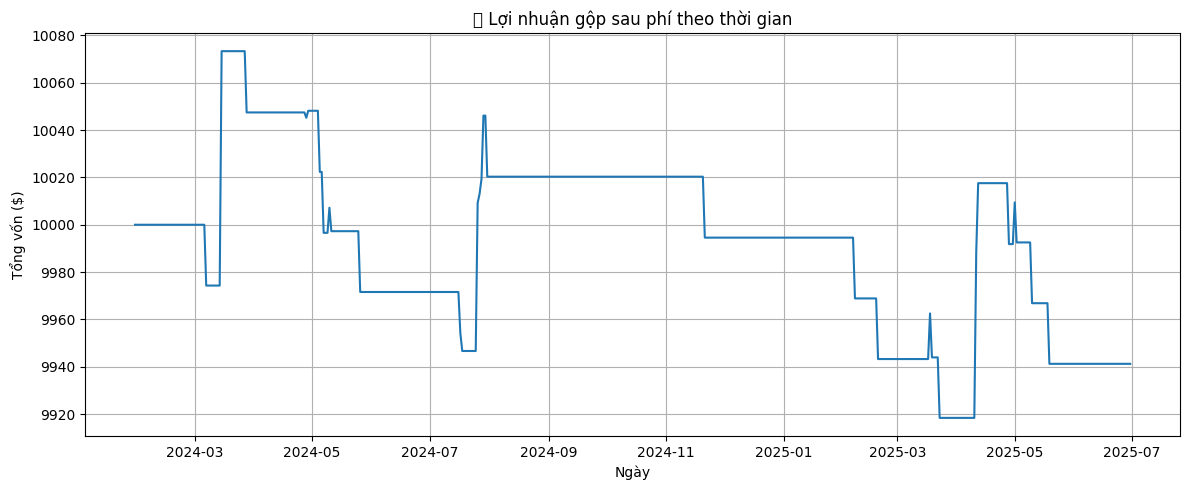

In [ ]:
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import uuid

# --- THÔNG SỐ CHIẾN LƯỢC ---
BIN_SIZE = 0.01
TOLERANCE = 0.005
TP = 0.2
SL = 0.005
LOOKAHEAD_N = 10
THRESHOLD = 0.6
initial_capital = 10000
FEE = 0.0007  # Phí giao dịch 0.07%
BREAK_EVEN_THRESHOLD = 0.05  # Ngưỡng lợi nhuận để dịch SL (5%)

# --- HÀM TẢI DỮ LIỆU TỪ BINANCE ---
def str_to_millis(date_str):
    dt = datetime.strptime(date_str, "%d/%m/%Y")
    return int(dt.timestamp() * 1000)

def fetch_binance_kline_df(symbol, interval, start_str, end_str):
    base_url = "https://api.binance.us/"
    api_url = "api/v3/klines"
    general_url = base_url + api_url

    start_time = str_to_millis(start_str)
    end_dt = datetime.strptime(end_str, "%d/%m/%Y").replace(hour=23, minute=59, second=59)
    end_time = int(end_dt.timestamp() * 1000)

    all_klines = []
    while start_time < end_time:
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000
        }
        response = requests.get(general_url, params=params)
        if response.status_code != 200:
            print("Error:", response.status_code, response.text)
            break

        data = response.json()
        if not data:
            break
        all_klines.extend(data)

        last_ts = data[-1][0]
        start_time = last_ts + 1
        time.sleep(0.2)

    df = pd.DataFrame(all_klines, columns=[
        "timestamp", "o", "h", "l", "c", "v",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
    ])
    df = df[["timestamp", "o", "c", "h", "l", "v"]]
    df.columns = ["timestamp", "o", "c", "h", "l", "v"]
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["o", "c", "h", "l", "v"]] = df[["o", "c", "h", "l", "v"]].astype(float)
    df["date"] = df["timestamp"].dt.date
    return df

# --- VOLUME PROFILE CHUẨN ---
def true_volume_profile(df, bin_size=BIN_SIZE):
    volume_map = {}
    for _, row in df.iterrows():
        low = row['l']
        high = row['h']
        volume = row['v']

        low_bin = round(low // bin_size * bin_size, 2)
        high_bin = round(high // bin_size * bin_size, 2)

        num_bins = int(round((high_bin - low_bin) / bin_size)) + 1
        price_bins = [round(low_bin + i * bin_size, 2) for i in range(num_bins)]
        volume_per_bin = volume / len(price_bins)

        for price in price_bins:
            volume_map[price] = volume_map.get(price, 0) + volume_per_bin

    vp_df = pd.DataFrame(list(volume_map.items()), columns=["price", "volume"])
    return vp_df.sort_values("volume", ascending=False).reset_index(drop=True)

def true_volume_profile_by_bin_count_ver2(df, num_bins=200):
    # 1. Get full price range
    min_price = df['l'].min()
    max_price = df['h'].max()

    # 2. Create bin edges
    bin_edges = np.linspace(min_price, max_price, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 3. Initialize volume map by index (not by float)
    volume_map = np.zeros(num_bins)

    # 4. Iterate through candles
    for _, row in df.iterrows():
        low = row['l']
        high = row['h']
        volume = row['v']

        # Find the bin indices that the candle touches
        bin_start = np.searchsorted(bin_edges, low, side='right') - 1
        bin_end = np.searchsorted(bin_edges, high, side='left')

        if bin_end < bin_start:
            bin_end = bin_start

        touched_bins = list(range(bin_start, bin_end + 1))
        volume_per_bin = volume / len(touched_bins) if touched_bins else 0

        for i in touched_bins:
            if 0 <= i < num_bins:
                volume_map[i] += volume_per_bin

    # 5. Build DataFrame using bin centers
    vp_df = pd.DataFrame({
        "price": np.round(bin_centers, 5),
        "volume": volume_map
    })

    return vp_df.sort_values("volume", ascending=False).reset_index(drop=True)

# --- PHÂN TÍCH HÀNH VI GIÁ QUANH VPOC ---
def survey_behavior(df, vpoc, breakout_threshold=0.015):
    outcomes = []
    for i in range(len(df) - LOOKAHEAD_N):
        price = df.iloc[i]['c']
        if abs(vpoc - price) / price >= TOLERANCE:
            future_high = df.iloc[i+1:i+1+LOOKAHEAD_N]['h']
            future_low = df.iloc[i+1:i+1+LOOKAHEAD_N]['l']
            if vpoc > price:
                if (future_high > price * (1 + breakout_threshold)).any():
                    outcomes.append("breakout")
                else:
                    outcomes.append("rejection")
            else:
                if (future_low < price * (1 - breakout_threshold)).any():
                    outcomes.append("breakout")
                else:
                    outcomes.append("rejection")
    return outcomes

# --- PHÂN TÍCH XÁC SUẤT TỪ 30 NGÀY TRƯỚC ---
def analyze_past_n_days_behavior(daily_data, reference_day_idx, lookback_days=30):
    outcomes = []
    for d in range(max(0, reference_day_idx - lookback_days), reference_day_idx):
        df_day = daily_data[sorted_dates[d]]
        # vpoc = true_volume_profile(df_day).iloc[0]['price']
        vpoc = true_volume_profile_by_bin_count_ver2(df_day).iloc[0]['price']
        day_outcomes = survey_behavior(df_day, vpoc)
        outcomes.extend(day_outcomes)
    return outcomes

# # --- NHẬP THỜI GIAN ---
# symbol = "ETHUSDT"
# interval = "30m"
# start_date = "01/06/2024"
# end_date = "30/06/2025"

# print("\U0001F4E5 Đang tải dữ liệu từ Binance...")
# df_all = fetch_binance_kline_df(symbol, interval, start_date, end_date)
# print(f"✅ Dữ liệu đã tải: {len(df_all)} dòng, từ {df_all['date'].min()} đến {df_all['date'].max()}")

# # --- TÁCH DỮ LIỆU ---
# daily_data = dict(tuple(df_all.groupby('date')))
# sorted_dates = sorted(daily_data.keys())
# if len(sorted_dates) < 30:
#     raise Exception("❌ Cần ít nhất 30 ngày dữ liệu!")

# --- BACKTEST ---
capital = initial_capital
capital_history = []
pnl_log = []
trade_log = []
open_trades = []
equity_list = []
sl_count = 0
tp_count = 0
negative_sl_total = 0
positive_sl_total = 0
tp_total = 0
print("\U0001F680 Bắt đầu backtest...\n")

for i in range(30, len(sorted_dates)):
    test_date = sorted_dates[i]
    df_test = daily_data[test_date]
    open_a_trade_today = False
    daily_realized_pnl = 0

    # === HANDLE OPEN TRADES ===
    for trade in open_trades:
        if trade["status"] != "open":
            continue

        for j in range(len(df_test)):
            high = df_test.iloc[j]['h']
            low = df_test.iloc[j]['l']
            current_time = df_test.iloc[j]['timestamp']
            entry_price = trade["entry_price"]
            decision = trade["direction"]
            sl_price = trade["sl_price"]  # FIX: Always get latest SL from trade

            # Breakeven logic
            if decision == "long" and high >= entry_price * (1 + BREAK_EVEN_THRESHOLD) and sl_price < entry_price * (1 + FEE):
                # print("move SL")
                trade["sl_price"] = entry_price * (1 + FEE)
                sl_price = trade["sl_price"]  # FIX: Refresh
            elif decision == "short" and low <= entry_price * (1 - BREAK_EVEN_THRESHOLD) and sl_price > entry_price * (1 - FEE):
                # print("move SL")
                trade["sl_price"] = entry_price * (1 - FEE)
                sl_price = trade["sl_price"]

            # TP/SL logic
            hit_tp = high >= entry_price * (1 + TP) if decision == "long" else low <= entry_price * (1 - TP)
            hit_sl = low <= sl_price if decision == "long" else high >= sl_price

            if hit_tp and hit_sl:
                # FIX: Decide priority (e.g. assume SL first)
                hit_tp = False

            if hit_tp:
                tp_count += 1
                trade["exit_price"] = entry_price * (1 + TP) if decision == "long" else entry_price * (1 - TP)
                trade["exit_time"] = current_time
                trade["result"] = TP
                tp_total += trade["result"]
                trade["status"] = "closed"
                trade["trade_id"] = str(uuid.uuid4())
                # print("hit TP", trade["result"])
                trade_log.append(trade)
                break
            elif hit_sl:
                sl_count += 1
                trade["exit_price"] = sl_price
                trade["exit_time"] = current_time
                trade["result"] = ((sl_price - entry_price) / entry_price) if decision == "long" else ((entry_price - sl_price) / entry_price)
                negative_sl_total += trade["result"] if trade["result"] < 0 else 0
                positive_sl_total += trade["result"] if trade["result"] > 0 else 0
                trade["status"] = "closed"
                trade["trade_id"] = str(uuid.uuid4())
                # print("hit SL", trade["result"])
                trade_log.append(trade)
                break

        if trade["status"] == "closed":
            amount = trade["amount"]
            if trade["direction"] == "long":
                gain = (trade["exit_price"] / entry_price) - 1
            else:
                gain = (entry_price / trade["exit_price"]) - 1
            daily_realized_pnl += amount * gain
            trade_log.append(trade)
            
    # Remove closed trades
    open_trades = [trade for trade in open_trades if t["status"] == "open"]

    # === NEW TRADE ENTRY ===
    if not open_a_trade_today:
        vpoc_day = sorted_dates[i - 1]
        df_vpoc = daily_data[vpoc_day]
        vpoc = true_volume_profile_by_bin_count_ver2(df_vpoc).iloc[0]['price']

        outcomes = analyze_past_n_days_behavior(daily_data, i, lookback_days=30)
        stats = Counter(outcomes)
        total = stats["breakout"] + stats["rejection"]
        breakout_prob = stats.get("breakout", 0) / total if total else 0
        rejection_prob = stats.get("rejection", 0) / total if total else 0

        for j in range(len(df_test)):
            price = df_test.iloc[j]['c']
            if abs(price - vpoc) / vpoc <= TOLERANCE:
                zone = "resistance" if vpoc > price else "support"

                if breakout_prob >= THRESHOLD:
                    decision = "short" if zone == "resistance" else "long"
                elif rejection_prob >= THRESHOLD:
                    decision = "long" if zone == "resistance" else "short"
                else:
                    continue

                entry_price = price
                position_size = capital / 10  # FIX: Use latest capital
                entry_time = df_test.iloc[j]['timestamp']

                trade = {
                    "direction": decision,
                    "entry_price": entry_price,
                    "entry_time": entry_time,
                    "amount": position_size,
                    "status": "open",
                    "sl_price": entry_price * (1 - SL) if decision == "long" else entry_price * (1 + SL)
                }

                # Simulate same-day TP/SL
                for k in range(j + 1, len(df_test)):
                    high = df_test.iloc[k]['h']
                    low = df_test.iloc[k]['l']
                    current_time = df_test.iloc[k]['timestamp']

                    # Breakeven SL move
                    if decision == "long" and high >= entry_price * (1 + BREAK_EVEN_THRESHOLD) and trade["sl_price"] < entry_price * (1 + FEE):
                        # print("move SL")
                        trade["sl_price"] = entry_price * (1 + FEE)
                    elif decision == "short" and low <= entry_price * (1 - BREAK_EVEN_THRESHOLD) and trade["sl_price"] > entry_price * (1 - FEE):
                        # print("move SL")
                        trade["sl_price"] = entry_price * (1 - FEE)

                    sl_price = trade["sl_price"]
                    hit_tp = high >= entry_price * (1 + TP) if decision == "long" else low <= entry_price * (1 - TP)
                    hit_sl = low <= sl_price if decision == "long" else high >= sl_price

                    if hit_tp and hit_sl:
                        hit_tp = False  # Assume SL happened first

                    if hit_tp:
                        tp_count += 1
                        trade["exit_price"] = entry_price * (1 + TP) if decision == "long" else entry_price * (1 - TP)
                        trade["exit_time"] = current_time
                        trade["result"] = TP
                        tp_total += trade["result"]
                        trade["status"] = "closed"
                        trade["trade_id"] = str(uuid.uuid4())
                        # print("hit TP", trade["result"] )
                        trade_log.append(trade)
                        break
                    elif hit_sl:
                        sl_count += 1
                        trade["exit_price"] = sl_price
                        trade["exit_time"] = current_time
                        trade["result"] = ((sl_price - entry_price) / entry_price) if decision == "long" else ((entry_price - sl_price) / entry_price)
                        negative_sl_total += trade["result"] if trade["result"] < 0 else 0
                        positive_sl_total += trade["result"] if trade["result"] > 0 else 0
                        trade["status"] = "closed"
                        # print("hit SL", trade["result"] )
                        trade["trade_id"] = str(uuid.uuid4())
                        trade_log.append(trade)
                        break

                # Add only if still open
                if trade["status"] == "open":
                    open_trades.append(trade)
                else:
                      gain = trade["result"]
                      # print("gain", gain)
                      amount = trade["amount"]
                      daily_realized_pnl += amount * (gain - FEE)
                      trade_log.append(trade)
                open_a_trade_today = True
                break  # One trade per day

    # --- Daily equity and capital ---
    # Add unrealized PnL

    unrealized_pnl = 0
    close = df_test.iloc[-1]['c']
    for t in open_trades:
        entry = t["entry_price"]
        amount = t["amount"]
        if t["direction"] == "long":
            gain = (close / entry) - 1
        else:
            gain = (entry / close) - 1
        unrealized_pnl += amount * gain

    capital += daily_realized_pnl
    # print(test_date)
    # print('daily_realized_pnl', daily_realized_pnl)
    # print('unrealized_pnl', unrealized_pnl)
    equity = capital + unrealized_pnl
    # print('equity', equity)
    # print('--------')
    # equity_list.append(equity)
    # === CAPITAL TRACKING ===
    free_capital = capital - sum(t["amount"] for t in open_trades)
    equity_list.append({"date": test_date, "equity": equity, "daily_realized_pnl": daily_realized_pnl, "unrealized_pnl": unrealized_pnl, "free_capital": free_capital})  
    # print(sum(t["amount"] for t in open_trades))
    # print(free_capital)
    # capital_plot = free_capital

    # for trade in open_trades:
    #     amount = trade["amount"]
    #     latest_price = df_test.iloc[-1]['c']
    #     entry = trade["entry_price"]
    #     gain = (latest_price - entry) / entry if t["direction"] == "long" else (entry - latest_price) / entry
    #     capital_plot += amount * (1 + gain)

    # for trade in trade_log:
    #     if trade["status"] == "closed" and trade["exit_time"].date() == test_date:
    #         amount = trade["amount"]
    #         capital_plot += amount * (1 + trade["result"]) * (1 - FEE)
    #         # print(amount)

    # capital_history.append(capital_plot)
    # pnl_log.append({"date": test_date, "capital": capital_plot})

    # Update base capital for next day (FIX)
    # capital = capital_plot

# --- TỔNG KẾT ---
print("\n\U0001F4D8 Tổng kết:")
print(f"Số lệnh: {len(trade_log)} | Vốn ban đầu: ${initial_capital:,.2f} → Cuối: ${equity:,.2f}")

pnl_log_df = pd.DataFrame(equity_list)
pnl_log_df.set_index("date", inplace=True)
pnl_log_df["equity"].plot(title="🧾 Lợi nhuận gộp sau phí theo thời gian", figsize=(12, 5), grid=True)
plt.xlabel("Ngày")
plt.ylabel("Tổng vốn ($)")
plt.tight_layout()
plt.show()

In [31]:
# equity_list
equity_list_df = pd.DataFrame(equity_list)

In [32]:
print(equity_list_df)
print(sum(equity_list_df['unrealized_pnl']))

           date       equity  daily_realized_pnl  unrealized_pnl  free_capital
0    2024-01-30  9994.300000           -5.700000        0.000000   9994.300000
1    2024-01-31  9994.300000            0.000000        0.000000   9994.300000
2    2024-02-01  9994.300000            0.000000        0.000000   9994.300000
3    2024-02-02  9994.300000            0.000000        0.000000   9994.300000
4    2024-02-03  9988.603249           -5.696751        0.000000   9988.603249
..          ...          ...                 ...             ...           ...
513  2025-06-26  9322.496536           -5.316854        0.000000   9322.496536
514  2025-06-27  9317.182713           -5.313823        0.000000   9317.182713
515  2025-06-28  9375.033429            0.000000       57.850715   8385.464442
516  2025-06-29  9391.843625            0.000000       74.660912   8385.464442
517  2025-06-30  9413.258417           -5.310794      101.386497   8380.153648

[518 rows x 5 columns]
12964.547790228935


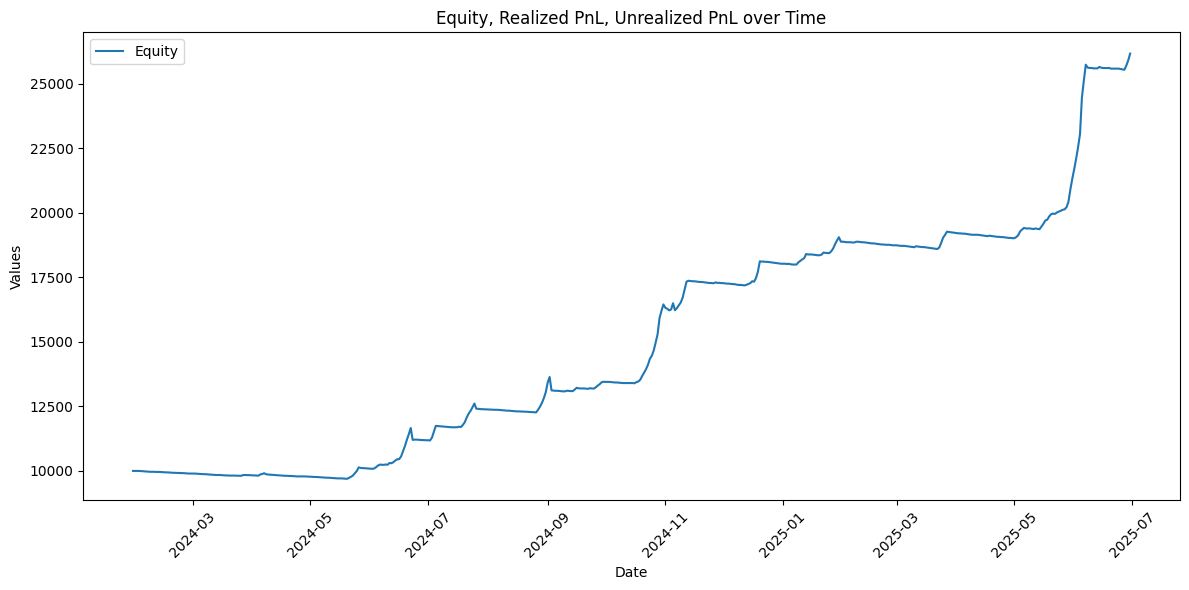

In [25]:
equity_list_df
plt.figure(figsize=(12, 6))

plt.plot(equity_list_df['date'], equity_list_df['equity'], label='Equity')
# plt.plot(equity_list_df['date'], equity_list_df['daily_realized_pnl'], label='Realized PnL')
# plt.plot(equity_list_df['date'], equity_list_df['unrealized_pnl'], label='Unrealized PnL')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Equity, Realized PnL, Unrealized PnL over Time')

plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()